## Feature selection

#### Correlation

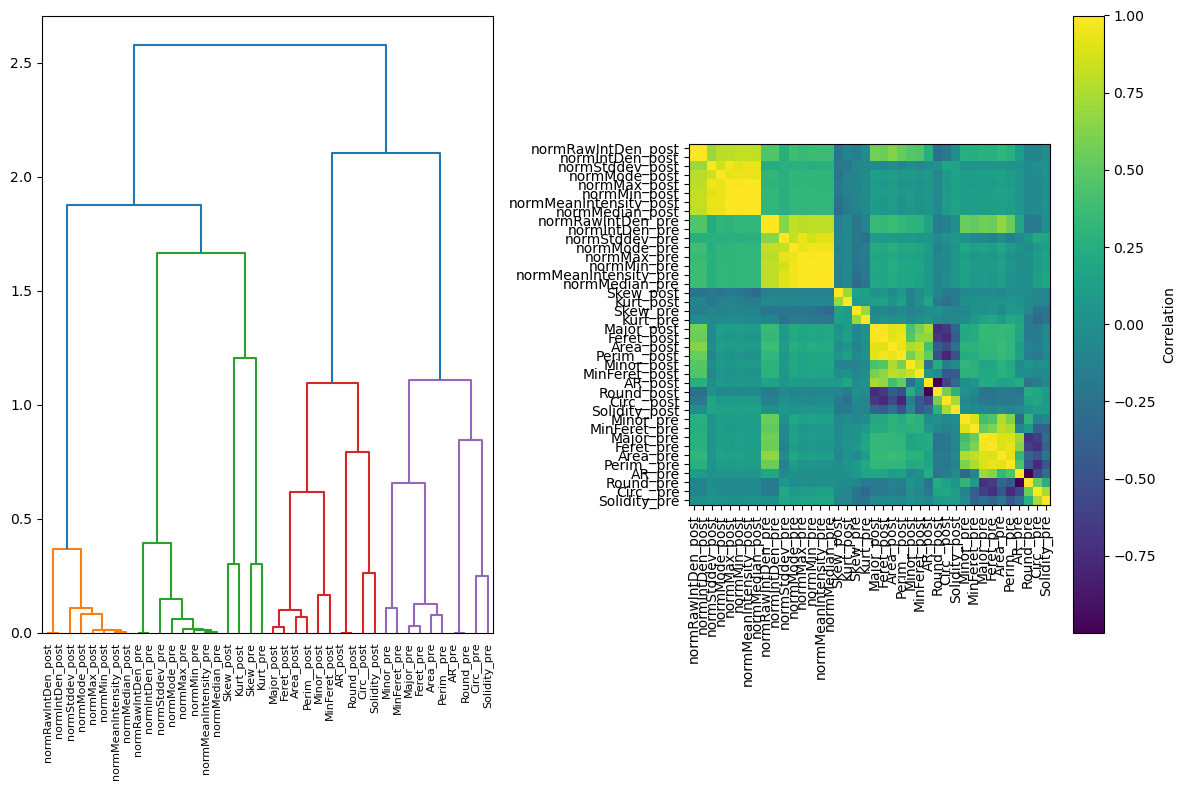

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(features).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=features.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

cax = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap='viridis')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])

# Add color bar
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical')
cbar.set_label('Correlation')

_ = fig.tight_layout()

In [ ]:
from collections import defaultdict

# Perform hierarchical clustering and generate cluster IDs for each data point
cluster_ids = hierarchy.fcluster(dist_linkage, 1.2, criterion="distance")

# Initialize a defaultdict to map each cluster ID to a list of feature indices
cluster_id_to_feature_ids = defaultdict(list)

# Iterate over the cluster IDs and map each cluster to its corresponding feature indices
for idx, cluster_id in enumerate(cluster_ids):
    # Append the current feature index (idx) to the list corresponding to its cluster ID
    cluster_id_to_feature_ids[cluster_id].append(idx)

# For each cluster, select the first feature index as the representative feature
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

# Retrieve the names of the selected features using their indices
selected_features_names = features.columns[selected_features]

# Print the names of the selected features
print(selected_features_names)

# Create a new DataFrame containing only the selected features
selected_features_df = features[selected_features_names]

# Display the first few rows of the selected features DataFrame
selected_features_df.head()


Index(['Area_post', 'Skew_post', 'normMeanIntensity_post', 'Area_pre',
       'Skew_pre', 'normMeanIntensity_pre'],
      dtype='object')


,Area_post,Skew_post,normMeanIntensity_post,Area_pre,Skew_pre,normMeanIntensity_pre
0,0.192,0.708,0.761285,0.151,0.560,0.843947
1,0.202,0.386,0.740903,0.192,0.568,1.290268
2,0.263,0.349,0.557227,0.222,0.202,1.043221
3,0.222,0.662,0.752314,0.333,0.126,1.200072
4,0.202,0.527,0.613588,0.242,0.603,0.709965


## Stacking to get feature importances

In [ ]:
# Assuming your dataset is in a DataFrame df and the target column is 'Marker'
X = selected_features_df
y = target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.head()

,Area_post,Skew_post,normMeanIntensity_post,Area_pre,Skew_pre,normMeanIntensity_pre
23938,0.172,0.279,0.796232,0.263,0.542,1.134795
5144,0.202,0.552,0.849286,0.323,0.691,0.772302
13594,0.323,0.831,1.091254,0.192,0.532,1.790440
5846,0.101,0.519,0.886962,0.394,0.557,0.800299
6777,0.252,0.732,0.307577,0.364,0.529,0.557329


#### Parameter Optimization (optional, I did not run)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each classifier
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly']
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
}

optimal_params = {}

for class1, class2 in class_pairs:
    print(f"\nProcessing pair: {class1} vs {class2}")

    # Filter the dataset for the current pair of classes
    mask = y.isin([class1, class2])
    X_pair = selected_features_df[mask]
    y_pair = y[mask]

    print(f"Filtered pair dataset shape: {X_pair.shape}")

    # Use StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for clf_name, clf in classifiers.items():
        print(f"Optimizing classifier: {clf_name}")
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[clf_name], cv=skf, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_pair, y_pair)

        optimal_params[(class1, class2, clf_name)] = grid_search.best_params_
        print(f"Best params for {class1} vs {class2} with {clf_name}: {grid_search.best_params_}")

print("Optimal parameters for all class pairs and classifiers:")
for key, value in optimal_params.items():
    print(f"{key}: {value}")


#### Classification

In [ ]:
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from imblearn.combine import SMOTETomek
import pandas as pd
import numpy as np

class_pairs = list(combinations(y.unique(), 2))
results = {}
feature_importances = {}
roc_coords = {}

print(f"Number of class pairs to process: {len(class_pairs)}")

# Define classifiers
classifiers = {
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42)
}

for class1, class2 in class_pairs:
    print(f"\nProcessing pair: {class1} vs {class2}")

    # Filter the dataset for the current pair of classes
    mask = y.isin([class1, class2])
    X_pair = selected_features_df[mask]
    y_pair = y[mask]

    print(f"Filtered pair dataset shape: {X_pair.shape}")

    # Use StratifiedKFold for out-of-fold predictions
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for clf_name, clf in classifiers.items():
        print(f"Processing classifier: {clf_name}")
        fold_reports = []
        fold_importances = []
        all_y_true = []
        all_y_proba = []

        for fold, (train_index, test_index) in enumerate(skf.split(X_pair, y_pair)):
            print(f"  Processing fold {fold + 1}/{skf.get_n_splits()}")
            X_train, X_test = X_pair.iloc[train_index], X_pair.iloc[test_index]
            y_train, y_test = y_pair.iloc[train_index], y_pair.iloc[test_index]

            # Apply SMOTETomek to the training data
            print("    Applying SMOTETomek...")
            smote_tomek = SMOTETomek(random_state=42)
            X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

            # Train the classifier
            print("    Training classifier...")
            clf.fit(X_resampled, y_resampled)

            # Predict and evaluate the classifier
            print("    Making predictions and evaluating classifier...")
            y_pred = clf.predict(X_test)
            y_proba = clf.predict_proba(X_test)[:, 1]  # Probability of the positive class
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            fold_reports.append(report)
            all_y_true.extend(y_test)
            all_y_proba.extend(y_proba)
            print(f"    Fold accuracy for {class1} vs {class2} with {clf_name}: {accuracy:.2f}")

            # Calculate feature importances
            print("    Calculating feature importances...")
            perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
            fold_importances.append(perm_importance.importances_mean)

        # Aggregate fold results
        mean_report = {}
        for key in fold_reports[0].keys():
            if isinstance(fold_reports[0][key], dict):
                mean_report[key] = {metric: np.mean([fold[key][metric] for fold in fold_reports]) for metric in fold_reports[0][key]}
            else:
                mean_report[key] = np.mean([fold[key] for fold in fold_reports])
        results[(class1, class2, clf_name)] = mean_report

        # Aggregate feature importances
        mean_importance = np.mean(fold_importances, axis=0)
        feature_importances[(class1, class2, clf_name)] = mean_importance
        print(f"  Completed processing for classifier: {clf_name}")

        # Calculate ROC coordinates
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba, pos_label=class2)
        roc_auc = auc(fpr, tpr)
        roc_coords[(class1, class2, clf_name)] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

    print(f"Completed evaluation for {class1} vs {class2}")

print("All class pairs processed.")


Number of class pairs to process: 15

Processing pair: CCK vs GFP
Filtered pair dataset shape: (12630, 6)
Processing classifier: SVM
  Processing fold 1/5
    Applying SMOTETomek...
    Training classifier...
    Making predictions and evaluating classifier...
    Fold accuracy for CCK vs GFP with SVM: 0.75
    Calculating feature importances...
  Processing fold 2/5
    Applying SMOTETomek...
    Training classifier...
    Making predictions and evaluating classifier...
    Fold accuracy for CCK vs GFP with SVM: 0.75
    Calculating feature importances...
  Processing fold 3/5
    Applying SMOTETomek...
    Training classifier...
    Making predictions and evaluating classifier...
    Fold accuracy for CCK vs GFP with SVM: 0.75
    Calculating feature importances...
  Processing fold 4/5
    Applying SMOTETomek...
    Training classifier...
    Making predictions and evaluating classifier...
    Fold accuracy for CCK vs GFP with SVM: 0.77
    Calculating feature importances...
  Proce

In [ ]:
# Function to flatten the nested dictionary structure for saving to CSV
def flatten_dict(d):
    flat_dict = {}
    for outer_key, inner_dict in d.items():
        if isinstance(inner_dict, dict):
            for inner_key, value in inner_dict.items():
                flat_dict[f'{outer_key}_{inner_key}'] = value
        else:
            flat_dict[outer_key] = inner_dict
    return flat_dict

# Save results to CSV
results_df = pd.DataFrame([flatten_dict(report) for report in results.values()])
results_df.insert(0, 'Class Pair', [f'{pair[0]} vs {pair[1]} ({pair[2]})' for pair in results.keys()])
results_df.to_csv('RESULTS.csv', index=False)

# Save feature importances to CSV
feature_importances_df = pd.DataFrame(feature_importances).T
feature_importances_df.columns = selected_features_df.columns
feature_importances_df.insert = [0, 'Class Pair', [f'{pair[0]} vs {pair[1]} ({pair[2]})' for pair in feature_importances.keys()]]
feature_importances_df.to_csv('FEATURE_IMPORTANCES.csv')

# Save ROC coordinates to CSV
roc_coords_flat = []
for (class1, class2, clf_name), roc_data in roc_coords.items():
    for fpr, tpr in zip(roc_data['fpr'], roc_data['tpr']):
        roc_coords_flat.append({
            'Class Pair': f'{class1} vs {class2} ({clf_name})',
            'FPR': fpr,
            'TPR': tpr,
            'AUC': roc_data['auc']
        })

roc_coords_df = pd.DataFrame(roc_coords_flat)
roc_coords_df.to_csv('ROC_COORDS.csv', index=False)
